In [1]:
import psycopg2, psycopg2.extras, psycopg2.pool, pickle, json, matplotlib, sys, time
from multiprocessing import Pool, Manager
from collections import OrderedDict
import numpy as np; import pandas as pd
from sqlalchemy import create_engine
import seaborn as sns
%matplotlib inline

In [2]:
con = create_engine("postgresql://anderstj@127.0.0.1:5432/users-per-sqkm")

In [14]:
query_string = """SELECT 
tiles_per_year_2005.quadkey,
tiles_per_year_2006.quadkey,
tiles_per_year_2007.quadkey,
tiles_per_year_2008.quadkey,
tiles_per_year_2009.quadkey,
tiles_per_year_2010.quadkey,
tiles_per_year_2011.quadkey,
tiles_per_year_2012.quadkey,
tiles_per_year_2013.quadkey,
tiles_per_year_2014.quadkey,
tiles_per_year_2015.quadkey,
tiles_per_year_2016.quadkey
FROM  tiles_per_year_2005, tiles_per_year_2006, tiles_per_year_2007, 
      tiles_per_year_2008, tiles_per_year_2009, 
      tiles_per_year_2010, tiles_per_year_2011,
      tiles_per_year_2012, tiles_per_year_2013,
      tiles_per_year_2014, tiles_per_year_2015,
      tiles_per_year_2016
WHERE tiles_per_year_2005.quadkey = tiles_per_year_2006.quadkey AND
      tiles_per_year_2006.quadkey = tiles_per_year_2007.quadkey AND
      tiles_per_year_2007.quadkey = tiles_per_year_2008.quadkey AND
      tiles_per_year_2008.quadkey = tiles_per_year_2009.quadkey AND
      tiles_per_year_2009.quadkey = tiles_per_year_2010.quadkey AND
      tiles_per_year_2010.quadkey = tiles_per_year_2011.quadkey AND
      tiles_per_year_2011.quadkey = tiles_per_year_2012.quadkey AND
      tiles_per_year_2012.quadkey = tiles_per_year_2013.quadkey AND
      tiles_per_year_2013.quadkey = tiles_per_year_2014.quadkey AND
      tiles_per_year_2014.quadkey = tiles_per_year_2015.quadkey AND
      tiles_per_year_2015.quadkey = tiles_per_year_2016.quadkey
LIMIT 10;"""

In [ ]:
x = pd.read_sql_query(query_string,con=con,)

In [9]:
x

,quadkey,avg
0,021212321313,0.998481
1,021331333320,0.998889
2,021331333322,0.998901
3,021333111100,0.998913
4,021333111102,0.999251
5,021333111120,0.998859
6,021333111122,0.998546
7,021333111300,0.999350
8,021333111302,0.999166
9,021333111321,0.998855


In [16]:
for tile in study_tiles:
    tile['df'] = get_annual_averages(tile['quad'])
    print(tile['name'])

032211203001 ............Port Au Prince, Haiti
132312223332 .........

/usr/local/lib/python3.4/dist-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


...Tacloban, Philippines
033330222101 ............Monrovia, Liberia
123131221200 ............Trisuli Bazar, Nepal
120203320232 ............Heidelberg, Germany
031313131103 ............London, UK
032010110132 ............Manhattan, NY


In [17]:
for i, t in enumerate(study_tiles):
    print(i, t['name'])

0 Port Au Prince, Haiti
1 Tacloban, Philippines
2 Monrovia, Liberia
3 Trisuli Bazar, Nepal
4 Heidelberg, Germany
5 London, UK
6 Manhattan, NY


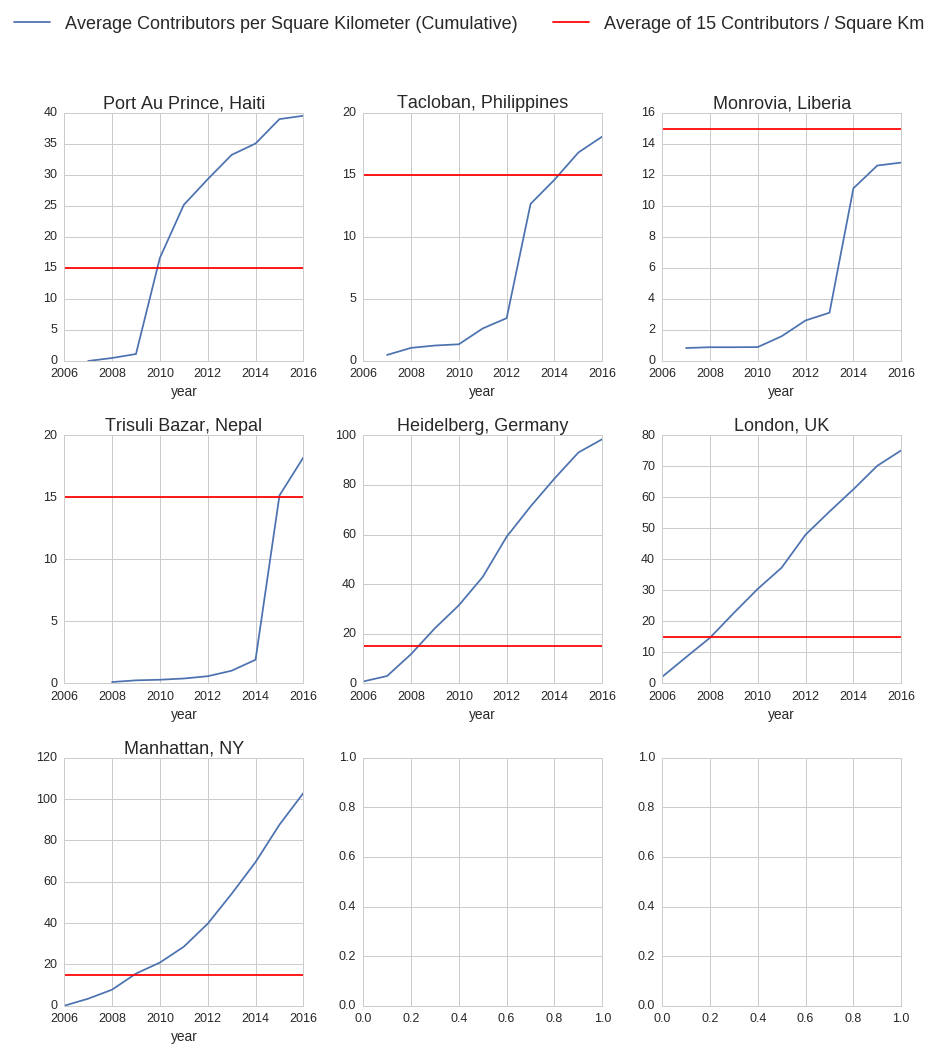

In [18]:
sns.set(font_scale=1.25)
plt.style.use('seaborn-whitegrid')
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15,16), facecolor='w', edgecolor='k')
plt.subplots_adjust(wspace=0.25, hspace=0.3)

for ax, (idx, tile) in zip(axs.ravel(), enumerate(study_tiles)):
    
    df = tile['df']
    
    df.plot(ax=ax,x='year', y='running_average', legend=False)
    
#     df['total_active_users']  = df.users_new_obj + df.users_edited_obj
    
    ax.plot([2006,2016],[15,15], color='red')

    ax.set_xlim(2006,2016)
    ax.set_title(tile['name'],fontsize=18)
    
plt.figlegend( ax.get_lines(),
              [ "Average Contributors per Square Kilometer (Cumulative)",
                "Average of 15 Contributors / Square Km"],
                 loc = ('upper center'), ncol=3, fontsize=18)

## Interpretation

For very popular areas of the map such as Manhattan or London, we see a fairly constant rate of growth in the number of contributors per square kilometer.

For areas of the map which have been the subject of disaster mapping, the time of activation is... quite obvious

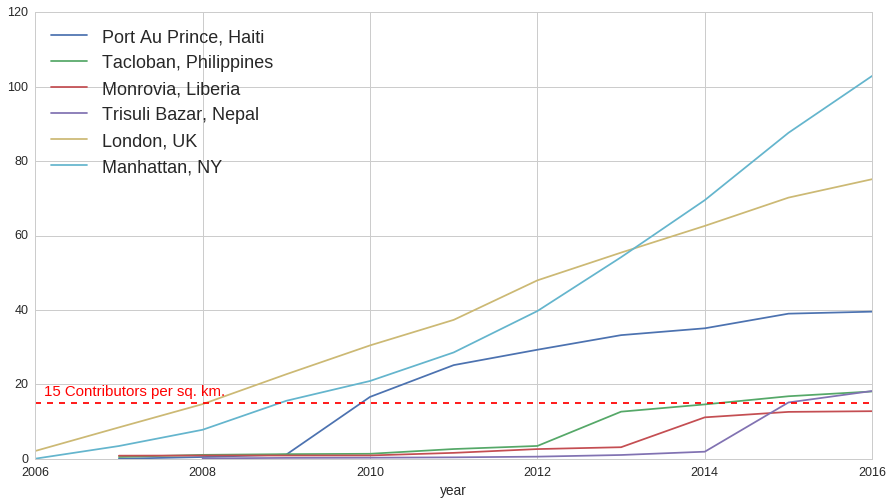

In [19]:
sns.set(font_scale=1.25)
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(1)
fig.set_size_inches(15,8)
labels = []

for tile in study_tiles[:4]+study_tiles[-2:]:

    df = tile['df']
    
    df.plot(ax=ax,x='year', y='running_average', legend=False)
    
    ax.set_xlim(2006,2016)
    
    labels.append(tile['name'])


ax.plot([2006,2016],[15,15], color='red', linestyle='--')
ax.text(2006.1,17,"15 Contributors per sq. km.", color='red')
plt.legend( ax.get_lines(), labels, loc = 'upper left', fontsize=18)

Here is how a few of these tiles measure up to one-another. Haklay identified in 2010 that 15 contributors per sq. km. is the point at which data became 'very good' (and comparable to official survey data in the region).

### How big is each tile? 
Tiles are different sizes because of different latitudes in the pseudo-mercator projection. Tiles near the equator are upwards of 90 square kilometers.

In [20]:
for tile in study_tiles:
    print(tile['name'])
    print(tile['df'].tile_area.values[0])

Port Au Prince, Haiti
85.9822
Tacloban, Philippines
92.1003
Monrovia, Liberia
94.5831
Trisuli Bazar, Nepal
74.6887
Heidelberg, Germany
40.5223
London, UK
37.0372
Manhattan, NY
54.9418


# How do study tiles compare to _similar tiles_?

### 1. Iterate through study tiles, fetching stats for all comparable tiles

In [21]:
for tile in study_tiles:
    print("\r" + tile['name'], len(tile['compare_tiles']))
    for t in tile['compare_tiles']:
        t['df'] = get_annual_averages(t['quad'])

Port Au Prince, Haiti 1
Tacloban, Philippines 1
132303033313 ............

/usr/local/lib/python3.4/dist-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


Monrovia, Liberia 1
Trisuli Bazar, Nepal 1
Heidelberg, Germany 37
London, UK 17
Manhattan, NY 8
120220011030 ............031331123312 ............120220330313 ............021212222131 ............030222231030 ............032010033002 ............023010230020 ............032300212020 ............

# Compare Study Tiles to Average of Similar Tiles

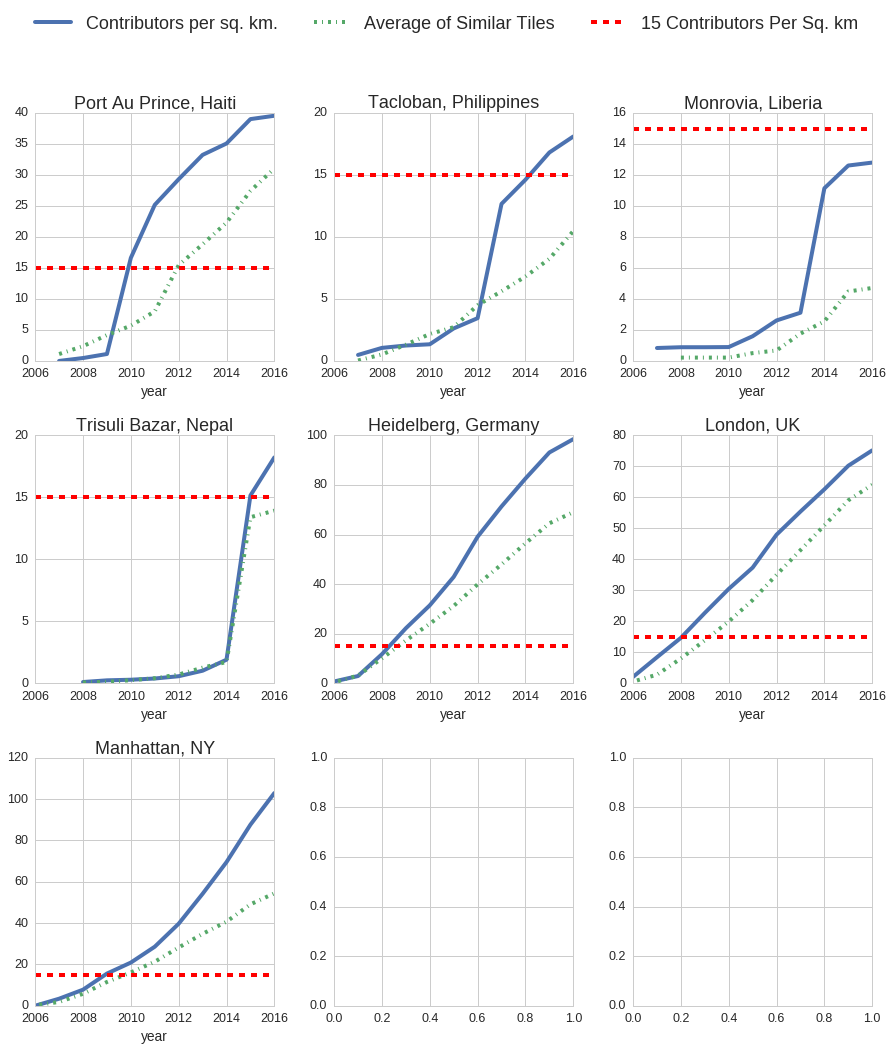

In [22]:
sns.set(font_scale=1.25)
plt.style.use('seaborn-whitegrid')
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15,16), facecolor='w', edgecolor='k')
plt.subplots_adjust(wspace=0.25, hspace=0.3)


for ax, (idx, tile) in zip(axs.ravel(), enumerate(study_tiles)):
    
    ax = tile['df'].plot(ax=ax,x='year',y='running_average',lw=4)

    if len(tile['compare_tiles'])>0:
        compare_df = pd.DataFrame()
        for t in tile['compare_tiles']:
            compare_df = pd.concat([compare_df,t['df']])

        avg = compare_df.groupby('year').aggregate({'running_average' : pd.Series.mean})
        avg.plot(ax=ax, y='running_average',linestyle="-.",lw=4)

    ax.set_xlim(2006,2016)
    
    ax.set_title(tile['name'])

    line, = ax.plot([2006,2016],[15,15], color='red', linestyle='--',lw=4)
    
    ax.legend_.remove()
    handles, labels = ax.get_legend_handles_labels()

    ax.set_title(tile['name'], fontsize=18)

plt.figlegend( [handles[0],handles[1], line],
               ["Contributors per sq. km.","Average of Similar Tiles", "15 Contributors Per Sq. km"], 
               loc=('upper center'), ncol=3, fontsize=18)

In [26]:
for i, t in enumerate(study_tiles):
    print(i, t['name'])

0 Port Au Prince, Haiti
1 Tacloban, Philippines
2 Tacloban, Philippines
3 Trisuli Bazar, Nepal
4 Heidelberg, Germany
5 London, UK
6 Manhattan, NY


## Create Plot for Paper

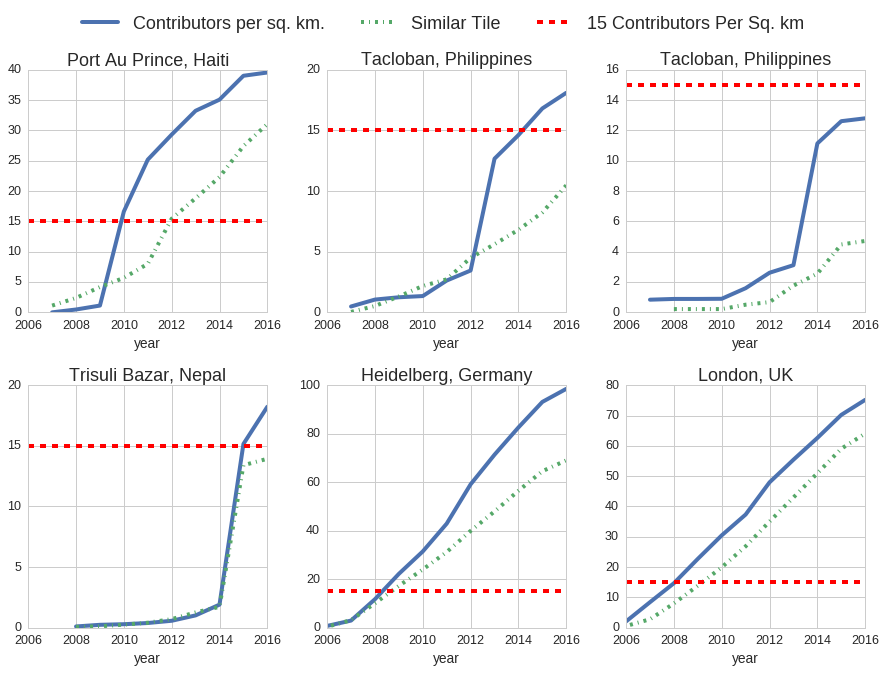

In [31]:
sns.set(font_scale=1.25)
plt.style.use('seaborn-whitegrid')
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15,10), facecolor='w', edgecolor='k')
plt.subplots_adjust(wspace=0.25, hspace=0.3)

for ax, (idx, tile) in zip(axs.ravel(), enumerate(study_tiles)):
    
    ax = tile['df'].plot(ax=ax,x='year',y='running_average',lw=4)

    if len(tile['compare_tiles'])>0:
        compare_df = pd.DataFrame()
        for t in tile['compare_tiles']:
            compare_df = pd.concat([compare_df,t['df']])

        avg = compare_df.groupby('year').aggregate({'running_average' : pd.Series.mean})
        avg.plot(ax=ax, y='running_average',linestyle="-.",lw=4)

    ax.set_xlim(2006,2016)
    
    ax.set_title(tile['name'])

    line, = ax.plot([2006,2016],[15,15], color='red', linestyle='--',lw=4)
    
    ax.legend_.remove()
    handles, labels = ax.get_legend_handles_labels()

    ax.set_title(tile['name'], fontsize=18)

plt.figlegend( [handles[0],handles[1], line],
               ["Contributors per sq. km.","Similar Tile", "15 Contributors Per Sq. km"], 
               loc=('upper center'), ncol=3, fontsize=18)